# Семинар №6

In [1]:
import cv2
import numpy as np

import skimage.segmentation
import skimage.data
import skimage.io
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

seed = 42
np.random.seed(seed)

# Подготовим данные

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [3]:
centers = [[1, 1], [-1, -1], [1, -1]]
blobs = make_blobs(n_samples=750, centers=centers, cluster_std=0.5, random_state=seed) 

X, y = blobs
X = StandardScaler().fit_transform(X)

In [4]:
def plot_xy_set(X, labels):
    unique_labels = set(labels)

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

    plt.title("Estimated number of clusters: %d" % len(unique_labels))

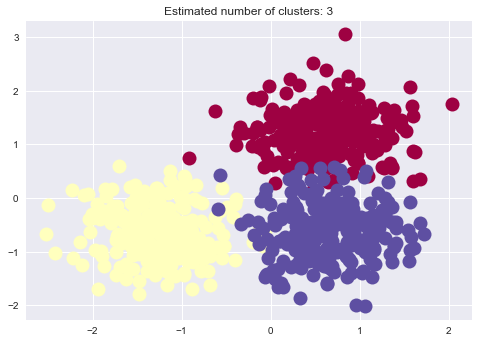

In [5]:
plot_xy_set(X, y)

## kNN 

In [6]:
from sklearn.cluster import KMeans

In [7]:
# Compute clustering
print("Compute structured hierarchical clustering...")
n_clusters = 3  # number of regions
ward = KMeans(n_clusters, random_state=seed).fit(X)

label = ward.labels_
print("Number of frames: ", label.size)
print("Number of clusters: ", np.unique(label).size)

Compute structured hierarchical clustering...
Number of frames:  750
Number of clusters:  3


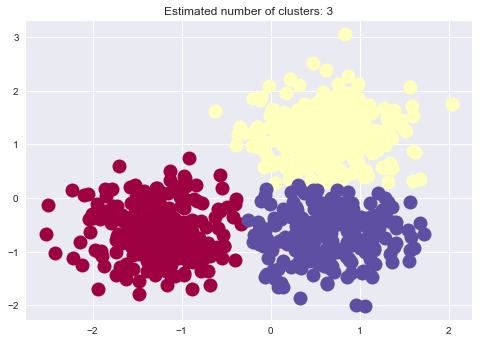

In [8]:
plot_xy_set(X, label)

## Agglomerative

In [9]:
from sklearn.cluster import AgglomerativeClustering

In [10]:
# Compute clustering
print("Compute structured hierarchical clustering...")
n_clusters = 5  # number of regions
ward = AgglomerativeClustering(n_clusters=None,
        linkage='ward', distance_threshold=10).fit(X)

label = ward.labels_
print("Number of frames: ", label.size)
print("Number of clusters: ", np.unique(label).size)

Compute structured hierarchical clustering...
Number of frames:  750
Number of clusters:  3


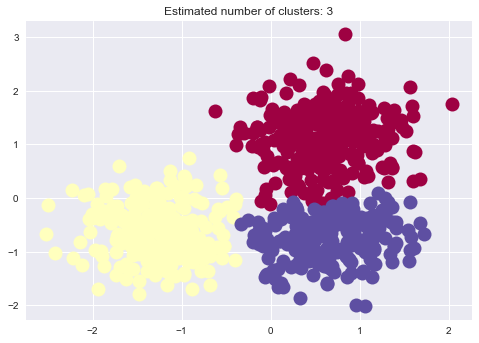

In [11]:
plot_xy_set(X, label)

## Mean-Shift 

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [13]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
print("Number of frames: ", label.size)
print("Number of clusters: ", np.unique(label).size)

Number of frames:  750
Number of clusters:  3


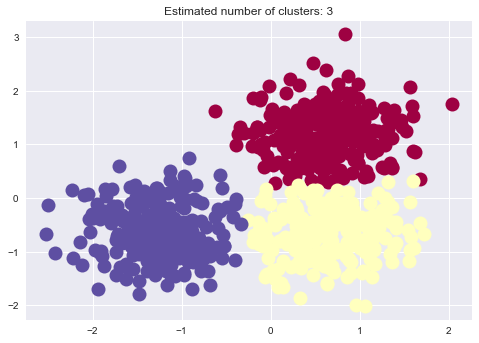

In [14]:
plot_xy_set(X, labels)

# Теперь для картинок 

In [15]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [16]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

# Вспомним про kNN 

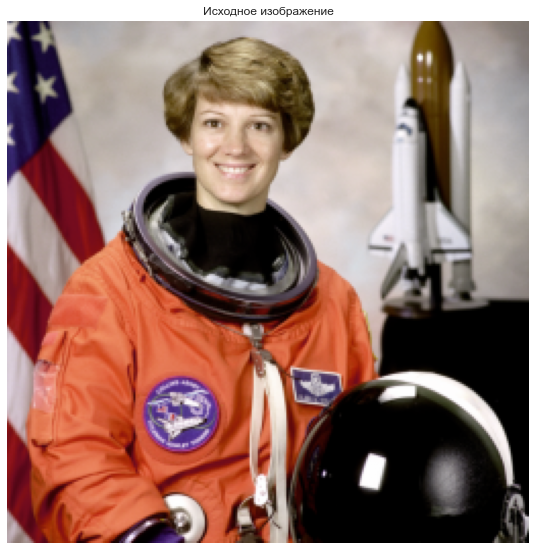

In [17]:
# Generate data
image = skimage.data.astronaut()
image = skimage.transform.resize(image, tuple(map(int, np.array(image.shape[:2])/2)))

plot_one_image(image)

In [18]:
print(image.shape)
X = np.reshape(image, (-1, 3))
print(X.shape)

(256, 256, 3)
(65536, 3)


In [19]:
n_clusters = 5  # number of regions
kmeans = KMeans(n_clusters=n_clusters, n_init=100, max_iter=500).fit(X)

label = np.reshape(kmeans.labels_, image.shape[:2])

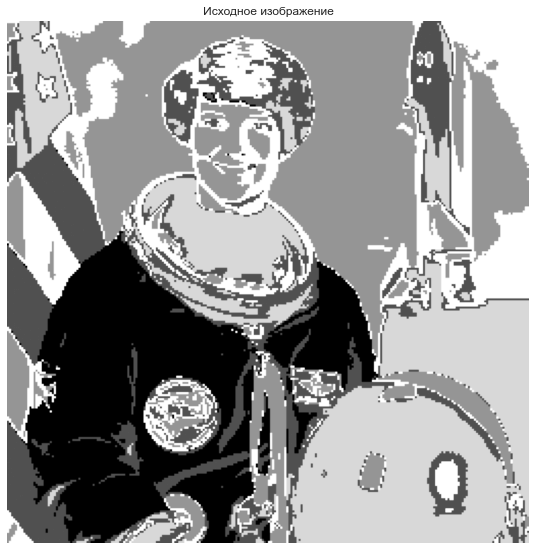

In [20]:
plot_one_image(label)

In [21]:
def reform_color_label(label):
    cmap = plt.cm.get_cmap('magma', label.max() + 1)
    rgba = cmap(np.linspace(0, 1, label.max() + 1))[:, :3]

    mask = np.zeros((*label.shape[:2], 3))
    for cls_idx in range(label.max() + 1):
        mask[label == cls_idx] = rgba[cls_idx]

    mask = (mask * 255).astype(np.uint8)
    
    return mask

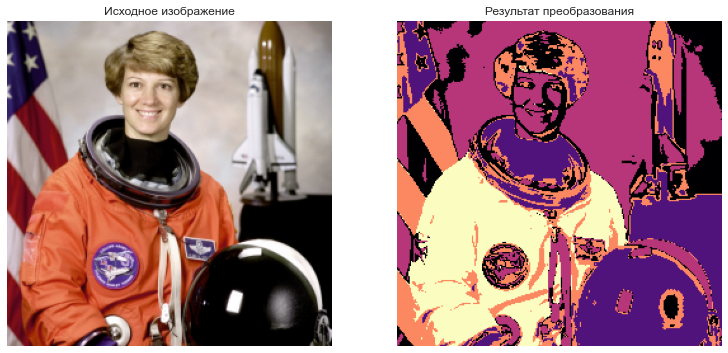

In [22]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

## Difference of spaces

In [23]:
image_hsv = skimage.color.rgb2hsv(image)
X = np.reshape(image_hsv[:, :, 0], (-1, 1))

In [24]:
n_clusters = 5  # number of regions
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', 
                                n_init=40, algorithm='elkan',
                                max_iter=1000).fit(X)

label = np.reshape(kmeans.labels_, image.shape[:2])

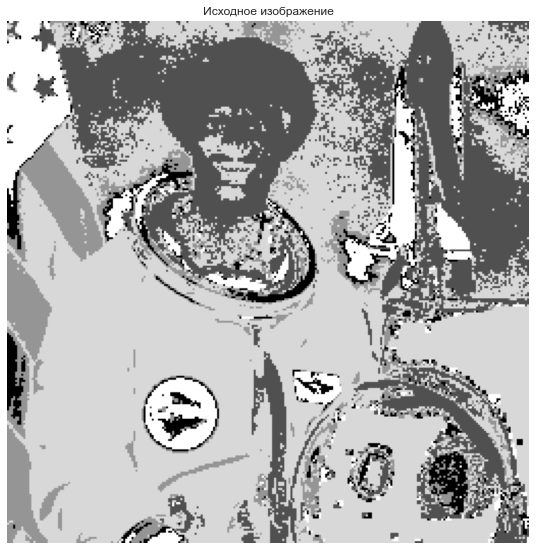

In [25]:
plot_one_image(label)

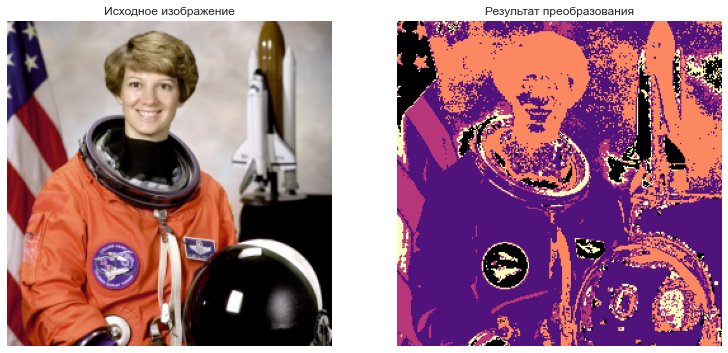

In [26]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

In [27]:
def plot_each_cls(image, label):
    n_clusters = np.unique(label).size
    cls_mask = np.zeros((*label.shape, n_clusters))

    for cls_idx in range(n_clusters):
        mask = label == cls_idx
        cls_mask[mask, cls_idx] = 1

    plt.figure(figsize=(6.4 * 3, 4.8 * 1))

    for cls_idx in range(n_clusters):
        plt.subplot(1, n_clusters, cls_idx + 1) 
        mask_ = np.repeat(cls_mask[..., cls_idx][..., np.newaxis], repeats=3, axis=2)
        plt.imshow(image * mask_)

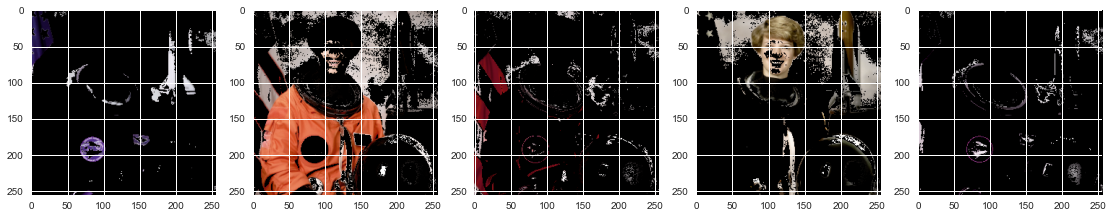

In [28]:
plot_each_cls(image, label)

In [29]:
img_blur = cv2.blur(image, (3,3))

laplacian = cv2.Laplacian((image * 255).astype(np.uint8), 3)
X = laplacian.reshape(-1, 3)

In [30]:
n_clusters = 5  # number of regions
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', 
                                n_init=40, algorithm='elkan',
                                max_iter=1000).fit(X)
label = np.reshape(kmeans.labels_, image.shape[:2])

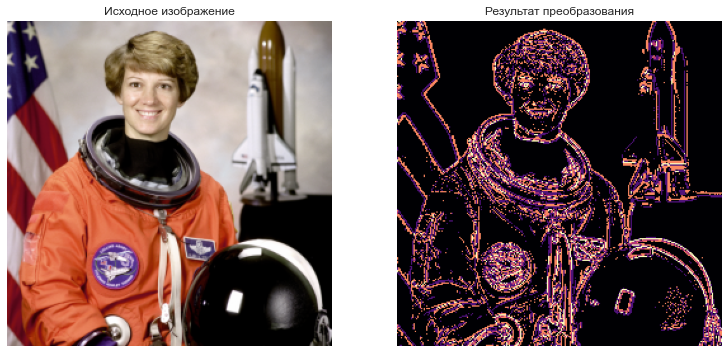

In [31]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

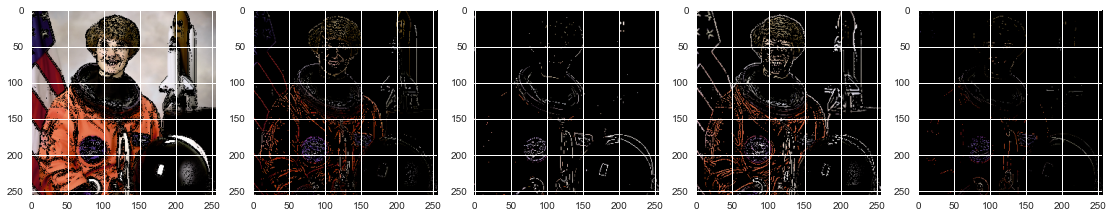

In [32]:
plot_each_cls(image, label)

# Agglomerative clustering

In [33]:
from sklearn.feature_extraction.image import grid_to_graph

In [34]:
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*image.shape[:2])

X = image.reshape(-1, 3)
ward = AgglomerativeClustering(n_clusters=5,
        linkage='ward', connectivity=connectivity, distance_threshold=None).fit(X)

label = np.reshape(ward.labels_, image.shape[:2])

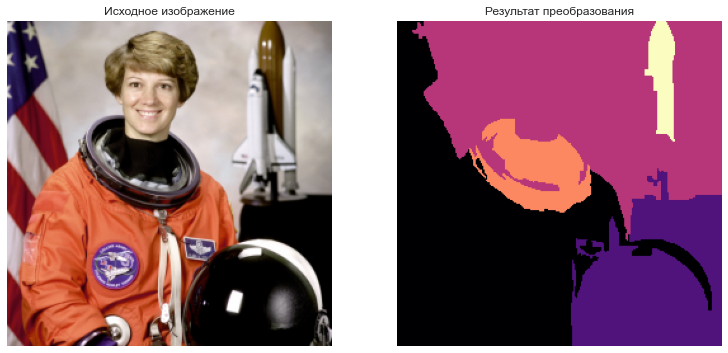

In [35]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

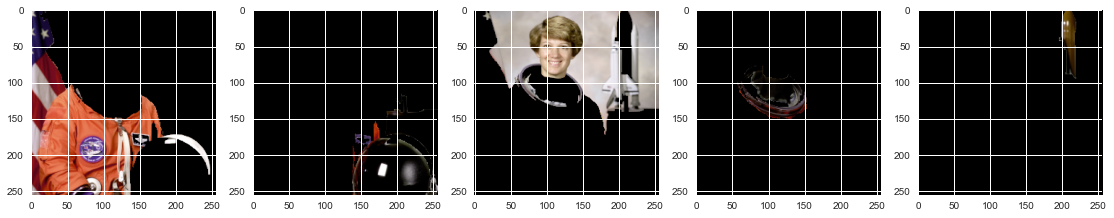

In [36]:
plot_each_cls(image, label)

In [37]:
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*image.shape[:2])

X = image_hsv.reshape(-1, 3)[:, :]
ward = AgglomerativeClustering(n_clusters=5,
        linkage='ward', connectivity=connectivity, distance_threshold=None).fit(X)

label = np.reshape(ward.labels_, image.shape[:2])

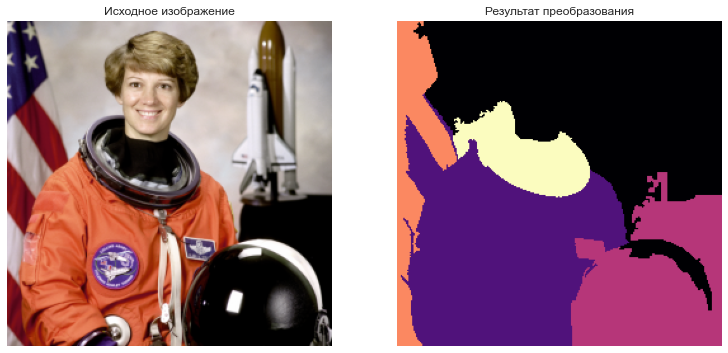

In [38]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

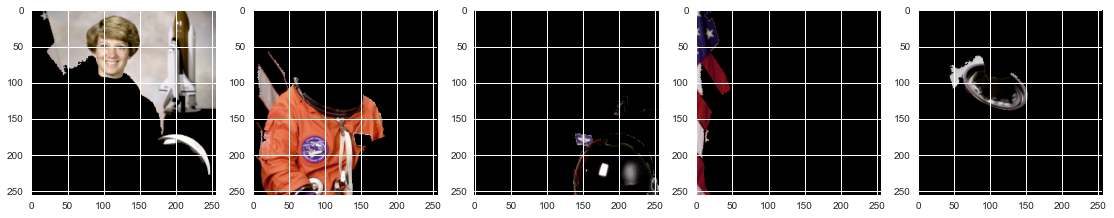

In [39]:
plot_each_cls(image, label)

# Mean-shift clustering

## sklearn 

In [40]:
# The following bandwidth can be automatically detected using
X = image.reshape(-1, 3)

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ward = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)

label = np.reshape(ward.labels_, image.shape[:2])
print("Number of clusters: ", np.unique(label).size)

Number of clusters:  3


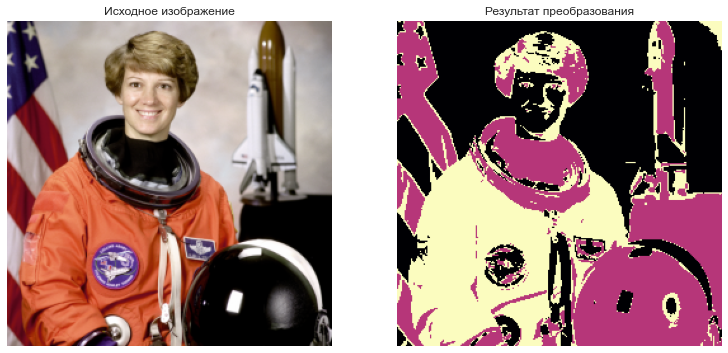

In [41]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

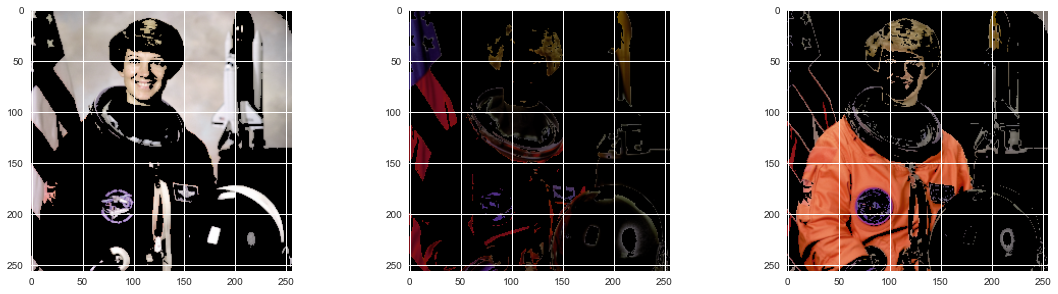

In [42]:
plot_each_cls(image, label)

In [43]:
# The following bandwidth can be automatically detected using
X = image_hsv.reshape(-1, 3)[:, :1]

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ward = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)

label = np.reshape(ward.labels_, image.shape[:2])
print("Number of clusters: ", np.unique(label).size)

Number of clusters:  5


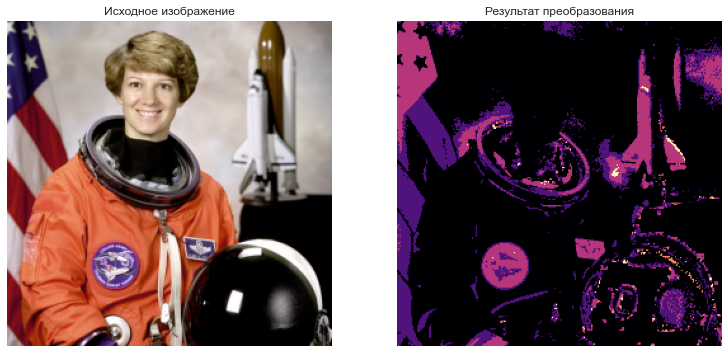

In [44]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

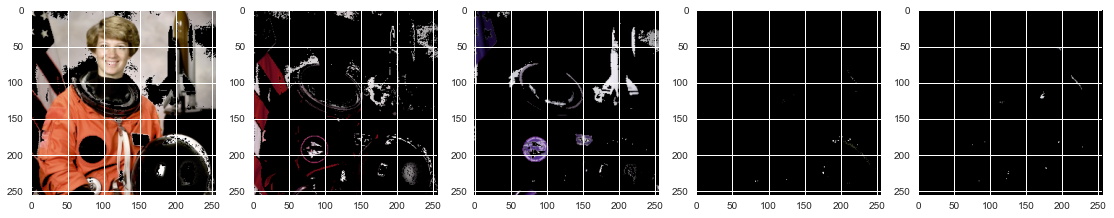

In [45]:
plot_each_cls(image, label)

## skimage 

In [46]:
label = skimage.segmentation.quickshift(image, ratio=0.5, kernel_size=20, 
                                        max_dist=6, sigma=1.0, convert2lab=False, 
                                        random_seed=seed)
print("Number of clusters: ", np.unique(label).size)

Number of clusters:  49


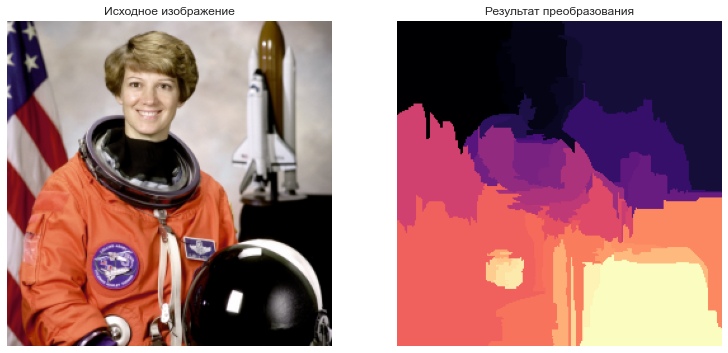

In [47]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

In [48]:
label = skimage.segmentation.quickshift(image, ratio=0.5, kernel_size=20, 
                                        max_dist=6, sigma=1.0, convert2lab=True, 
                                        random_seed=seed)
print("Number of clusters: ", np.unique(label).size)

Number of clusters:  163


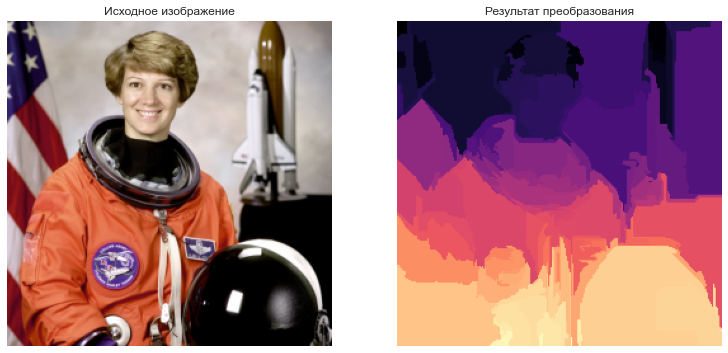

In [49]:
# Plot the results on an image
mask = reform_color_label(label)

plot_transform_result(image, mask)

# Watershed algo 

![](https://people.cmm.minesparis.psl.eu/users/beucher/lpe2.gif)

Ссылки:
1. https://en.wikipedia.org/wiki/Watershed_%28image_processing%29
2. https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html
3. Peer Neubert & Peter Protzel (2014). Compact Watershed and Preemptive SLIC: On Improving Trade-offs of Superpixel Segmentation Algorithms. ICPR 2014, pp 996-1001.

In [50]:
from scipy import ndimage as ndi

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank

In [51]:
image = skimage.data.coins()
uimage = skimage.color.rgb2gray(image)
denoised = -rank.median(uimage, disk(3))

markers = rank.gradient(denoised, disk(5)) < 40
markers, num_features = ndi.label(markers)

gradient = rank.gradient(denoised, disk(2))

plot_transform_result(-gradient, markers)

ValueError: the input array must have size 3 along `channel_axis`, got (303, 384)

In [ ]:
label = watershed(-gradient, markers)

In [ ]:
# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(label, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

# Segmentation metrics

In [ ]:
true_mask = np.zeros((400, 400, 3))
true_mask[50:100, 30:370] = 1

pred_mask = np.zeros((400, 400, 3))
pred_mask[20:60, :] = 1

In [ ]:
plot_transform_result(true_mask, pred_mask)

## Dice

In [ ]:
def dice_channel(probability, truth, threshold):
    batch_size = truth.shape[0]
    channel_num = truth.shape[3]
    mean_dice_channel = 0.
    all_channels = []
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = dice_single_channel(probability[i, :, :, j], truth[i, :, :, j], threshold)
            all_channels.append(channel_dice)
            mean_dice_channel += channel_dice/(batch_size * channel_num)
    return mean_dice_channel, all_channels


def dice_single_channel(probability, truth, threshold, eps=1E-9):
    t = (truth.flatten() > 0.5)
    p = (probability.flatten() > threshold)
    dice = (2.0 * (p * t).sum() + eps) / (p.sum() + t.sum() + eps)
    return dice

In [ ]:
mean_dice, all_dice = dice_channel(np.array([pred_mask]), np.array([true_mask]), 0.5)

print('Mean Dice:', mean_dice)
print('Dice per channel:', all_dice)

## Jaccard score

In [ ]:
def jaccard_score(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(np.mean, zip(*ious)) # mean accross images if per_image
    return np.array(tuple(ious))

In [ ]:
iou = jaccard_score(np.array([pred_mask]), np.array([true_mask]), C=2, EMPTY=0, per_image=False)

print('Mean IoU:', iou)
print('Dice per channel:', all_dice)